In [1]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import numpy as np
import os
import urllib.request

In [2]:
# Explore the CIFAR-10H dataset (located at ./data/cifar-10h)

# Download the CIFAR-10H data if it doesn't exist
if not os.path.exists('../data/cifar-10h'):
    os.makedirs('../data/cifar-10h', exist_ok=True)
    
    # Download CIFAR-10H data files
    base_url = "https://raw.githubusercontent.com/jcpeterson/cifar-10h/master/data/"
    files = ['cifar10h-counts.npy', 'cifar10h-probs.npy']
    
    for file in files:
        url = base_url + file
        urllib.request.urlretrieve(url, f'../data/cifar-10h/{file}')

# Load the CIFAR-10H data
counts = np.load('../data/cifar-10h/cifar10h-counts.npy')
probs = np.load('../data/cifar-10h/cifar10h-probs.npy')

print("CIFAR-10H counts shape:", counts.shape)
print("CIFAR-10H probabilities shape:", probs.shape)

print(counts[0])
print(probs[0])

CIFAR-10H counts shape: (10000, 10)
CIFAR-10H probabilities shape: (10000, 10)
[ 0  1  1 48  0  1  0  0  0  0]
[0.         0.01960784 0.01960784 0.94117647 0.         0.01960784
 0.         0.         0.         0.        ]


In [3]:
# Explore the CIFAR-10 dataset

# Load CIFAR-10 dataset

# This transform does two things:
# 1. Converts PIL images to PyTorch tensors (values 0-1)
# 2. Normalizes the RGB channels by subtracting mean (0.5) and dividing by std (0.5)
#    This scales values to roughly [-1, 1] which helps training
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = datasets.CIFAR10(root='../data/cifar-10', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='../data/cifar-10', train=False, download=True, transform=transform)

print("CIFAR-10 training set size:", len(trainset))
print("CIFAR-10 test set size:", len(testset))

# Print class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("CIFAR-10 classes:", classes)

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 training set size: 50000
CIFAR-10 test set size: 10000
CIFAR-10 classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


tensor([6, 9, 9, 4])


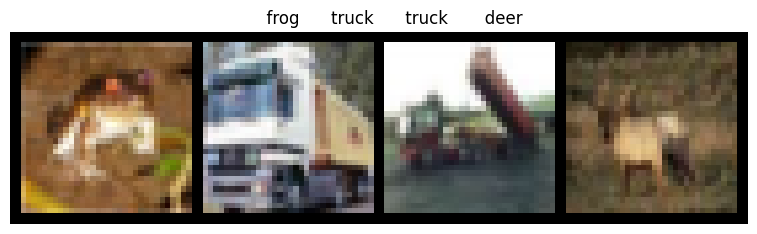

In [4]:
# Show some sample images
import matplotlib.pyplot as plt

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
import torch
dataiter = iter(torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False))
images, labels = next(dataiter)

print(labels)

# Show images
plt.figure(figsize=(10, 2.5))
imshow(torchvision.utils.make_grid(images))
plt.title(' '.join('%10s' % classes[labels[j]] for j in range(4)))
plt.show()

In [5]:
# See how much the hard label aligns with the soft labels across entire test set

# Create test dataloader for full dataset
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

correct = 0
total = 0

# Iterate through all test data
for images, labels in test_loader:
    total += labels.size(0)
    
    # Get batch indices
    batch_indices = list(range(total - labels.size(0), total))
    
    # Get predicted classes from soft labels for this batch
    predicted_classes = np.argmax(counts[batch_indices], axis=1)
    
    # Compare with hard labels
    correct += (predicted_classes == labels.numpy()).sum()
    
# Print out an example
print(f"Example {batch_indices[0]}:")
print(f"Hard label: {testset[batch_indices[0]][1]}")
print(f"Soft label: {counts[batch_indices[0]]}")

accuracy = (correct / total) * 100
print(f"Accuracy of soft labels matching hard labels across full test set: {accuracy:.2f}%")

Example 9900:
Hard label: 8
Soft label: [ 0  0  0  0  0  0  0  0 53  0]
Accuracy of soft labels matching hard labels across full test set: 99.21%


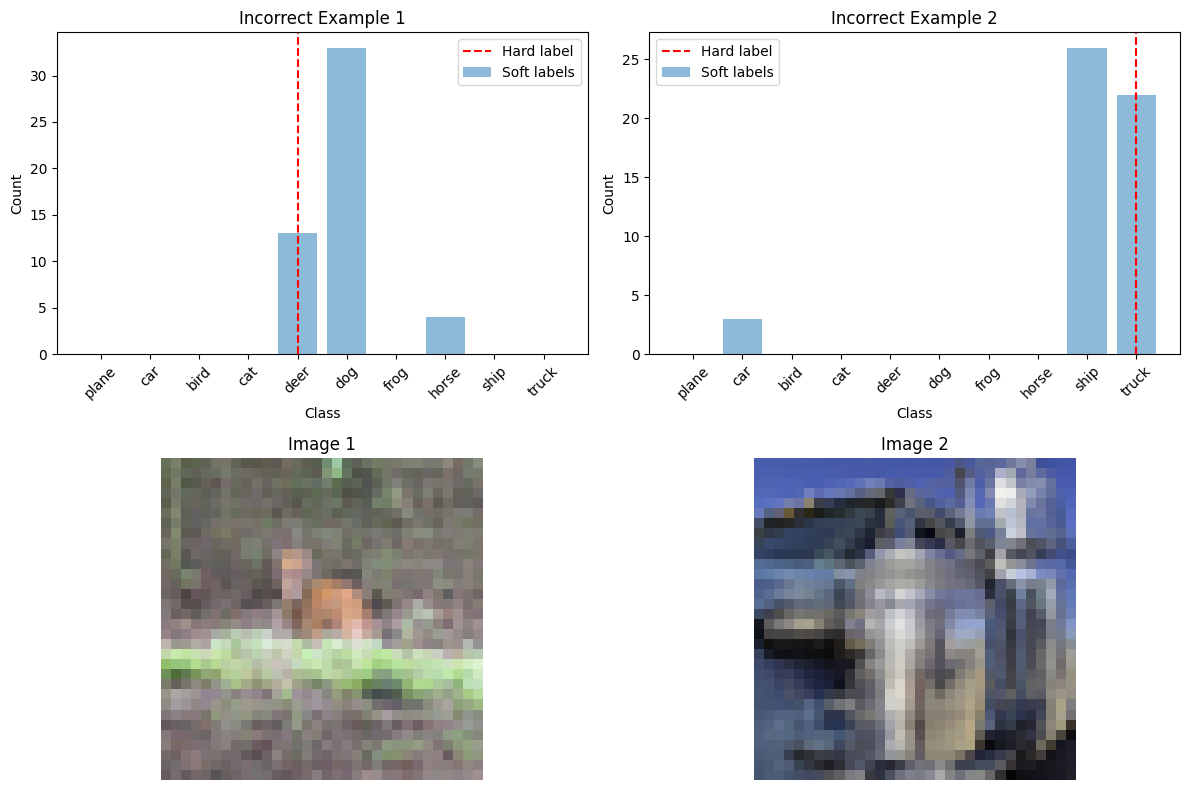

In [6]:
# Show distribution of soft vs hard labels for first two test examples
predictions = np.argmax(counts, axis=1)
actual = np.array([testset[i][1] for i in range(len(testset))])
incorrect = predictions != actual

incorrect_idx = np.where(incorrect)[0]

# Pick two incorrect examples instead since high variance example wasn't actually high variance
incorrect_example1 = incorrect_idx[0] 
incorrect_example2 = incorrect_idx[1]

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.bar(range(10), counts[incorrect_example1], alpha=0.5, label='Soft labels')
plt.axvline(x=testset[incorrect_example1][1], color='r', linestyle='--', label='Hard label')
plt.title('Incorrect Example 1')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.xticks(range(10), classes, rotation=45)

plt.subplot(2,2,2)
plt.bar(range(10), counts[incorrect_example2], alpha=0.5, label='Soft labels')
plt.axvline(x=testset[incorrect_example2][1], color='r', linestyle='--', label='Hard label')
plt.title('Incorrect Example 2') 
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.xticks(range(10), classes, rotation=45)

plt.subplot(2,2,3)
plt.imshow(testset[incorrect_example1][0].permute(1,2,0))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(testset[incorrect_example2][0].permute(1,2,0))
plt.title('Image 2')
plt.axis('off')

plt.tight_layout()
plt.show()

Median entropy: 0.10


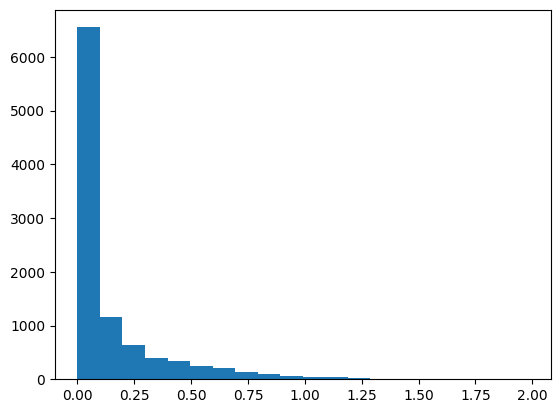

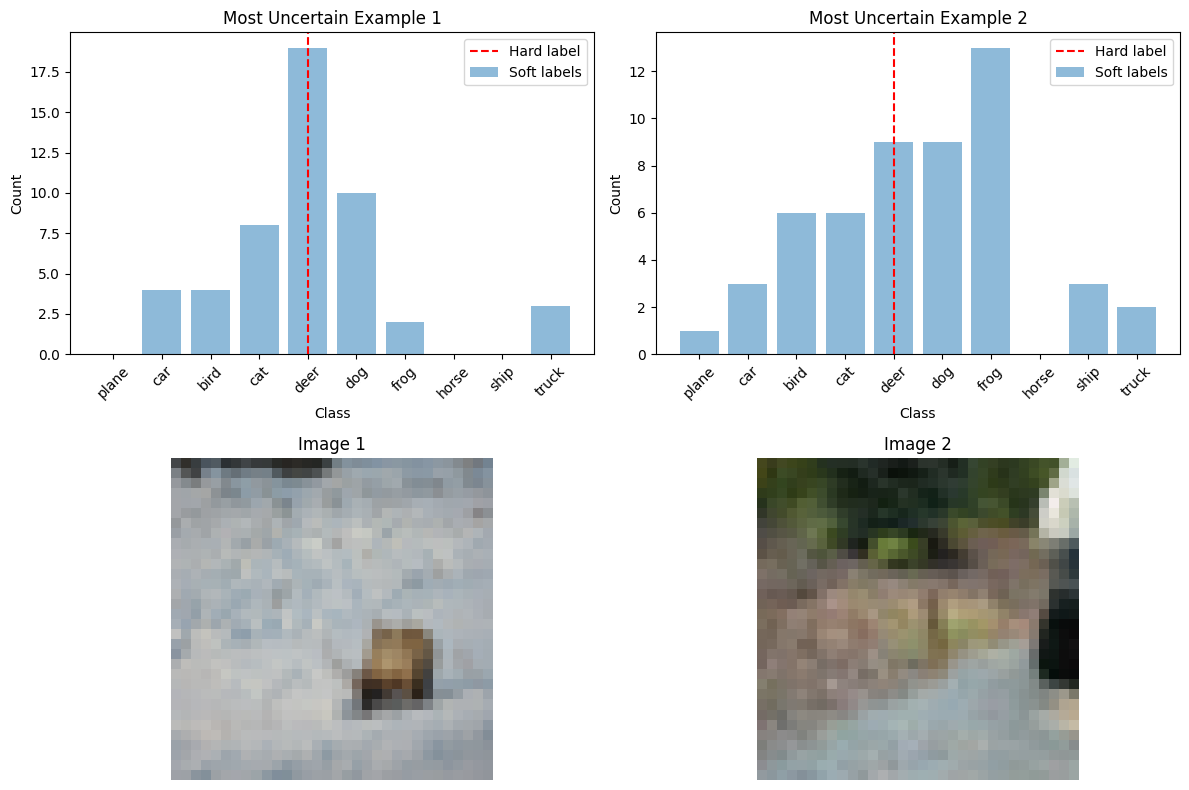

In [18]:
# Calculate entropy of soft labels for each example to measure uncertainty
# First normalize counts to get probabilities
probs = counts / counts.sum(axis=1, keepdims=True)
entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)  # Add small epsilon to avoid log(0)

# Get indices of examples with highest entropy (most uncertain predictions)
uncertain_idx = np.argsort(entropy)[-2:]  # Get top 2 most uncertain examples

# print median and distribution of entropy
print(f"Median entropy: {np.median(entropy):.2f}")
plt.hist(entropy, bins=20)

plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.bar(range(10), counts[uncertain_idx[0]], alpha=0.5, label='Soft labels')
plt.axvline(x=testset[uncertain_idx[0]][1], color='r', linestyle='--', label='Hard label')
plt.title('Most Uncertain Example 1')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.xticks(range(10), classes, rotation=45)

plt.subplot(2,2,2)
plt.bar(range(10), counts[uncertain_idx[1]], alpha=0.5, label='Soft labels')
plt.axvline(x=testset[uncertain_idx[1]][1], color='r', linestyle='--', label='Hard label')
plt.title('Most Uncertain Example 2')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.xticks(range(10), classes, rotation=45)

plt.subplot(2,2,3)
plt.imshow(testset[uncertain_idx[0]][0].permute(1,2,0))
plt.title('Image 1')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(testset[uncertain_idx[1]][0].permute(1,2,0))
plt.title('Image 2')
plt.axis('off')

plt.tight_layout()
plt.show()

## Image misclassification analysis

Median entropy: 0.10


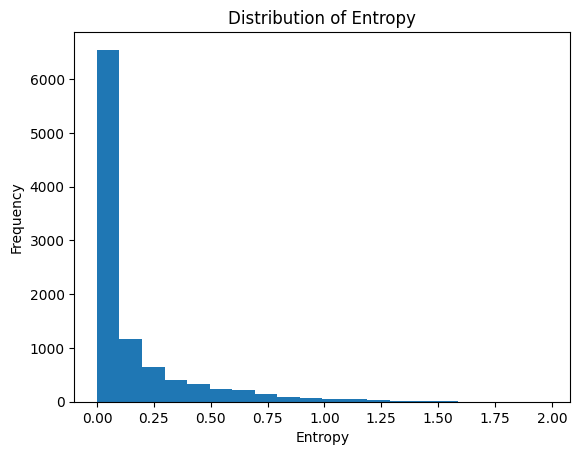

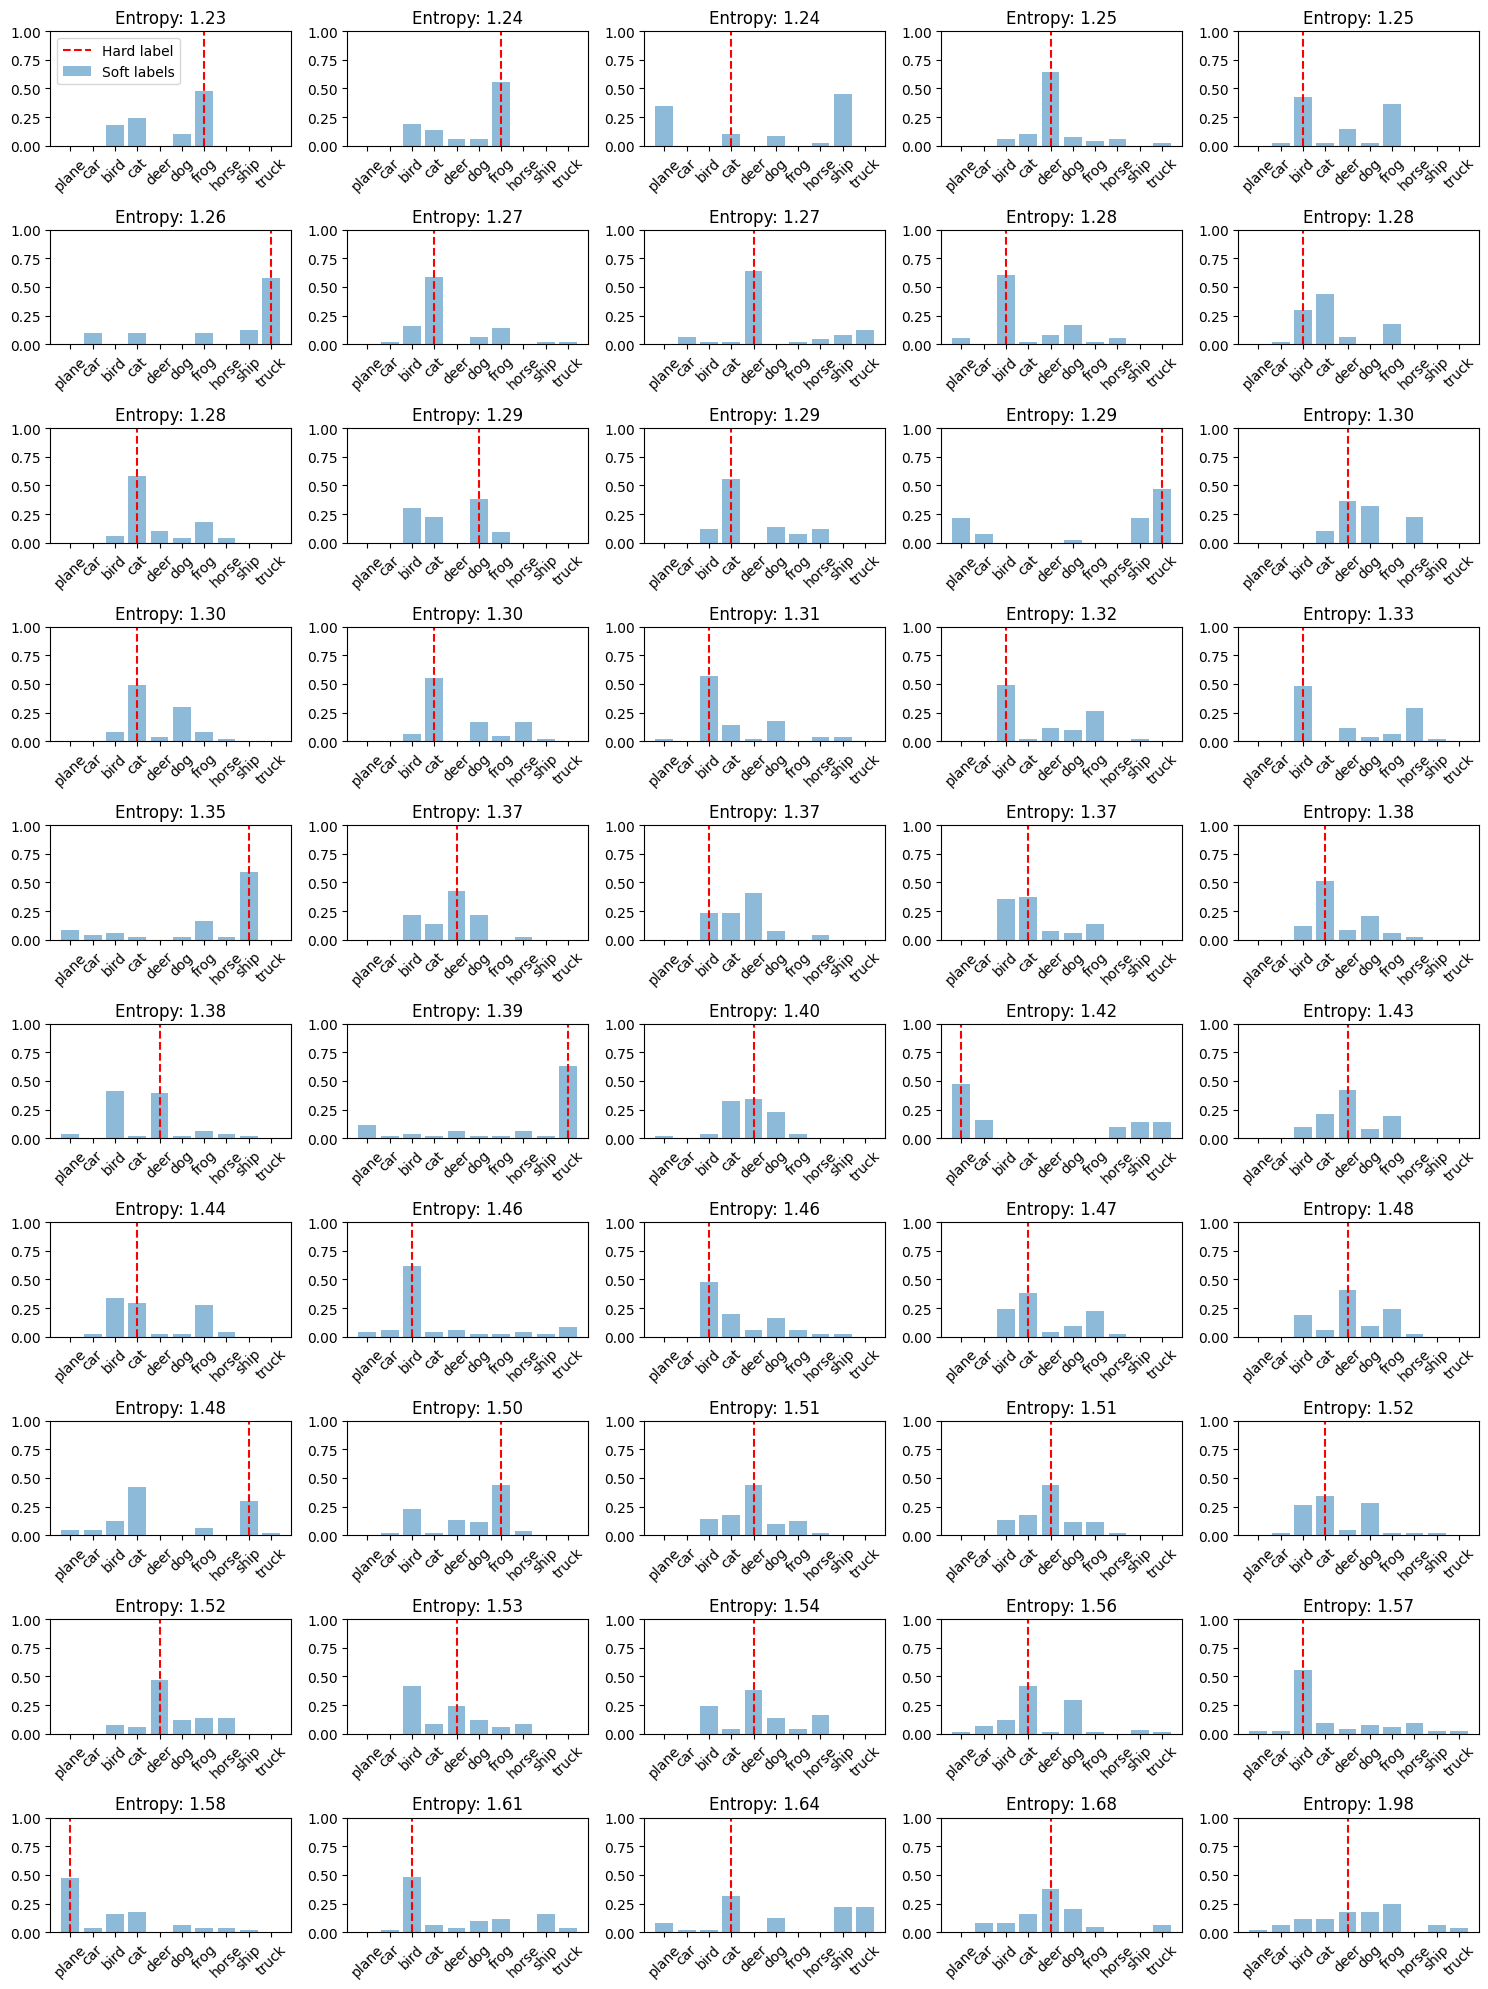

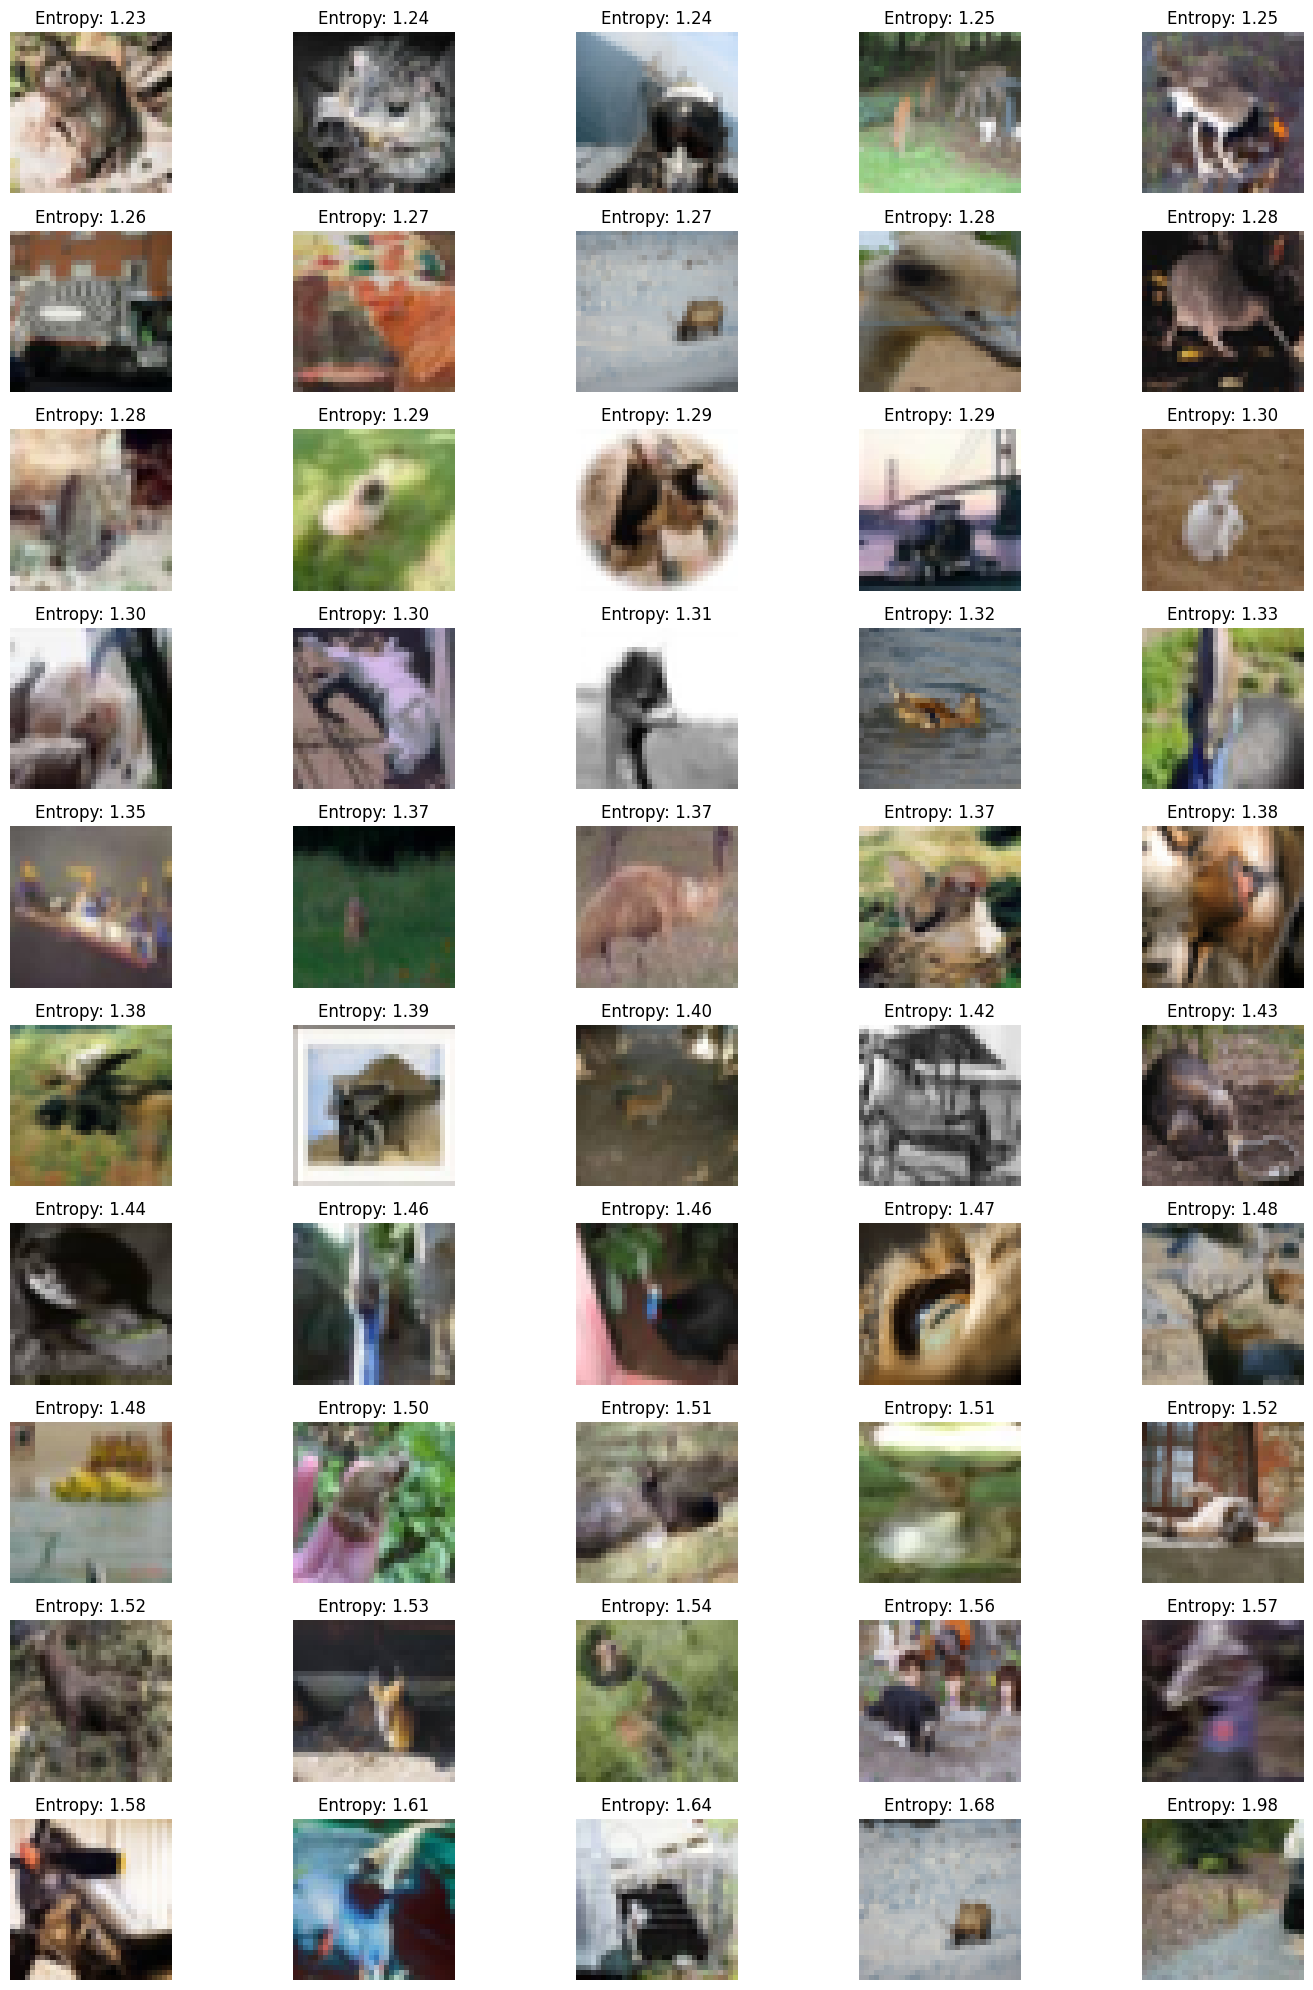

In [17]:
# Normalize counts into probability distributions
probs = counts / counts.sum(axis=1, keepdims=True)  # Normalize each row

# Calculate entropy of soft labels for each example to measure uncertainty
entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)  # Add small epsilon to avoid log(0)

# Get indices of examples with highest entropy (most uncertain predictions)
uncertain_idx = np.argsort(entropy)[-50:]  # Get top 50 most uncertain examples

# Print median and distribution of entropy
print(f"Median entropy: {np.median(entropy):.2f}")
plt.hist(entropy, bins=20)
plt.title('Distribution of Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.show()

# Plot soft labels and corresponding images for the top 50 uncertain examples
n_rows = 10  # Number of rows for the grid
n_cols = 5   # Number of columns for the grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

for i, idx in enumerate(uncertain_idx):
    row, col = divmod(i, n_cols)

    # Plot soft label distribution
    axes[row, col].bar(range(10), probs[idx], alpha=0.5, label='Soft labels')
    axes[row, col].axvline(x=testset[idx][1], color='r', linestyle='--', label='Hard label')
    axes[row, col].set_title(f'Entropy: {entropy[idx]:.2f}')
    axes[row, col].set_xticks(range(10))
    axes[row, col].set_xticklabels(classes, rotation=45)
    axes[row, col].set_ylim(0, 1)
    if i == 0:  # Add legend only for the first subplot
        axes[row, col].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Plot the corresponding images for the top 50 uncertain examples
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))

for i, idx in enumerate(uncertain_idx):
    row, col = divmod(i, n_cols)

    # Plot the image
    axes[row, col].imshow(testset[idx][0].permute(1, 2, 0))
    axes[row, col].set_title(f'Entropy: {entropy[idx]:.2f}')
    axes[row, col].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.stats import entropy

# Confusion Matrix (for highest prob soft label vs hard labels)
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show()

# Soft Co-occurrence Matrix (for soft labels)
def plot_soft_cooccurrence_matrix(probs):
    cooccurrence_matrix = np.dot(probs.T, probs) / probs.shape[0]  # Average pairwise probabilities
    plt.figure(figsize=(8, 6))
    sns.heatmap(cooccurrence_matrix, annot=True, cmap='coolwarm', xticklabels=classes, yticklabels=classes)
    plt.title('Soft Label Co-occurrence Matrix')
    plt.xlabel('Class')
    plt.ylabel('Class')
    plt.show()

# Function to add smoothing to avoid zero probabilities in KL divergence
def smooth_probs(probs, epsilon=1e-10):
    probs += epsilon
    probs /= probs.sum(axis=1, keepdims=True)
    return probs

# KL Divergence Matrix (for soft labels)
def plot_kl_divergence_matrix(probs):
    probs = smooth_probs(probs)
    kl_divergence_matrix = np.zeros((probs.shape[1], probs.shape[1]))
    for i in range(probs.shape[1]):
        for j in range(probs.shape[1]):
            kl_divergence_matrix[i, j] = np.mean(entropy(probs[:, i], probs[:, j]))
            # print(kl_divergence_matrix[i, j])
    plt.figure(figsize=(8, 6))
    sns.heatmap(kl_divergence_matrix, annot=True, cmap='coolwarm', xticklabels=classes, yticklabels=classes)
    plt.title('KL Divergence Between Classes')
    plt.xlabel('Class')
    plt.ylabel('Class')
    plt.show()


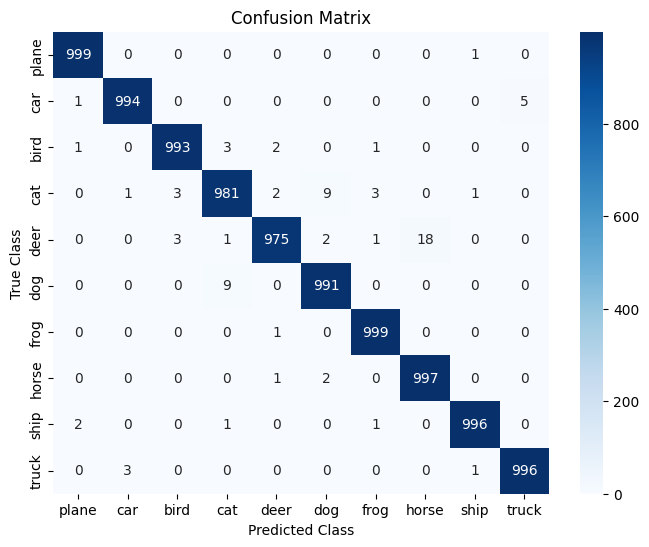

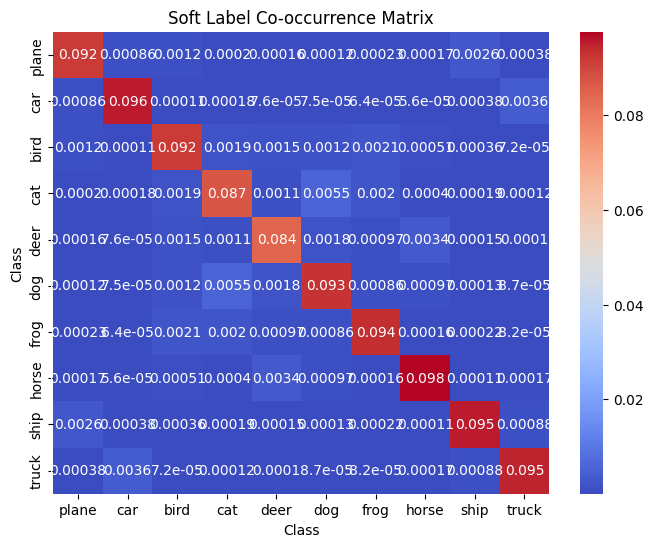

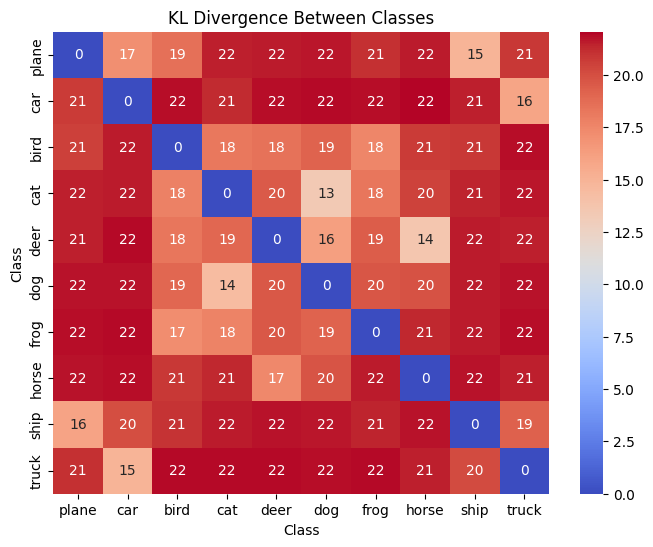

In [38]:
plot_confusion_matrix(actual, predictions)
plot_soft_cooccurrence_matrix(probs)
plot_kl_divergence_matrix(probs)